# midinet_noprevモデルの学習
nochordからさらに前小節の条件をなくしてみる．  
ここまでくるともはやただのDCGANである  
するとさすがにいい結果が出なくなったので，コード条件だけ追加してみる

In [1]:
import os, time, glob, ipdb, pickle, numpy as np
visible_devices = [2]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in visible_devices])

import torch, torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn.functional as F
from torch.nn.functional import relu, leaky_relu
from torch.utils.data import DataLoader
from multi_gpu import MultiGPUWrapper
from PIL import Image
from utils import Timer, get_model, count_params
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = "../datasets/theorytab/midinet"
input_data_path = os.path.join(base_dir, "midinetw.pkl")
output_dir = f"{base_dir}/learning"

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

## DataLoaderの作成

In [3]:
class MidinetDataset():
    def __init__(self, data_path, pitch_range=[0, 64], show_shape=False):
        data = pickle.load(open(data_path,'rb'))
        
        melody, prev, chord = [], [], []
        for m, p, c in data:
            melody.append(m)
            prev.append(p)
            chord.append(c)
        
        self.size = len(melody)
        steps = len(melody[0])
        bottom, top = pitch_range
        
        melody = np.array(melody)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        prev = np.array(prev)[:,:,bottom:top].reshape(self.size, 1, steps, top-bottom)
        chord = np.array(chord)
        
        if show_shape:
            print("melody shape", melody.shape)
            print("prev shape", prev.shape)
            print("condition shape", chord.shape)
        
        self.x = torch.from_numpy(melody).float()
        self.prev_x   = torch.from_numpy(prev).float()
        self.y  = torch.from_numpy(chord).float()

    def __getitem__(self, index):
        return self.x[index], self.prev_x[index], self.y[index]

    def __len__(self):
        return self.size

In [4]:
def get_dataloader(data_path, batch_size=72, shuffle=True):
    dataset = MidinetDataset(data_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    print('Data loading is completed.')
    print(f'{len(dataloader)} batches from {len(dataset)} bars are obtained.')
    return dataloader

動作確認用のDataLoader

In [5]:
with Timer():
    dataloader = get_dataloader(input_data_path, batch_size=2)

Data loading is completed.
42964 batches from 85927 bars are obtained.
Timer: 1.515962


## Modelの作成

model用共通関数の作成

In [6]:
def concat_vector(x, y):
    x_0, _, x_2, x_3 = x.shape               # 72, 1, 48, 64
    y2 = y.expand(x_0, y.shape[1], x_2, x_3) # 72, 48, 1, 1 -> 72, 48, 48, 64
    return torch.cat((x, y2),1)             # 72, 49, 48, 64
    
def batch_norm(x, eps=1e-05, momentum=0.9, affine=False):
    device = x.device
    if x.ndim == 2 or x.ndim == 3:
        norm = nn.BatchNorm1d(x.shape[1], eps=eps, momentum=momentum, affine=affine).to(device)
        return norm(x)
    elif x.ndim == 4:
        norm = nn.BatchNorm2d(x.shape[1], eps=eps, momentum=momentum, affine=affine).to(device)
        return norm(x)
    else:
        return x

def lrelu(x, slope=0.2):
    return leaky_relu(x, negative_slope=slope)

### Generator

prev_xを使わないようにする  

forwardの入力
- z (batch, noise_size) = (72, 100): ランダムノイズ
- y (batch, 48): コード条件

forwardの出力
- g_x (batch, ch, steps, pitch)= (72, 1, 48, 64): 生成された今の小節

ストライドが縦に2だったのは結果的にも速度的にもやっぱり関係なかったみたいなので1に直した

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, pitch_range=64):
        super(Generator, self).__init__()
        self.z_dim   = z_dim
        self.y_dim   = 48
        
        self.prev_ch = 0
        self.gf_dim  = 128
        self.gfc_dim = 1024

        self.h1      = nn.ConvTranspose2d(in_channels=self.gf_dim+self.y_dim+self.prev_ch, out_channels=pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h2      = nn.ConvTranspose2d(in_channels=pitch_range+self.y_dim+self.prev_ch, out_channels=pitch_range, kernel_size=(3,1), stride=(3,1))
        self.h3      = nn.ConvTranspose2d(in_channels=pitch_range+self.y_dim+self.prev_ch, out_channels=pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h4      = nn.ConvTranspose2d(in_channels=pitch_range+self.y_dim+self.prev_ch, out_channels=pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h5      = nn.ConvTranspose2d(in_channels=pitch_range+self.y_dim+self.prev_ch, out_channels=1, kernel_size=(1,pitch_range), stride=(1,1))

        self.linear1 = nn.Linear(self.z_dim + self.y_dim, self.gfc_dim)
        self.linear2 = nn.Linear(self.gfc_dim + self.y_dim, self.gf_dim*2*1)

    def forward(self, z, y):
        
        batch_size = len(z)
        
        yb = y.view(batch_size, self.y_dim, 1, 1)           # 72, 54, 1, 1

        z = torch.cat((z,y),1)                              # 72, 154

        h0 = F.relu(batch_norm(self.linear1(z)))            # 72, 1024
        h0 = torch.cat((h0,y),1)                            # 72, 1078

        h1 = F.relu(batch_norm(self.linear2(h0)))           # 72, 256
        h1 = h1.view(batch_size, self.gf_dim, 2, 1)         # 72, 128, 2, 1
        
        h1 = concat_vector(h1, yb)                          # 72, 182, 2, 1

        h2 = F.relu(batch_norm(self.h1(h1)))                # 72,  64, 4, 1 逆畳み込み． チャンネル数は固定で，3次元目が拡大される
        h2 = concat_vector(h2, yb)                          # 72, 118, 4, 1

        h3 = F.relu(batch_norm(self.h2(h2)))                # 72,  64, 12, 1 
        h3 = concat_vector(h3, yb)                          # 72, 118, 12, 1

        h4 = F.relu(batch_norm(self.h3(h3)))                # 72,  64, 24, 1
        h4 = concat_vector(h4, yb)                          # 72, 118, 24, 1
        
        h5 = F.relu(batch_norm(self.h4(h4)))                # 72,  64, 48, 1
        h5 = concat_vector(h5, yb)                          # 72, 118, 48, 1

        g_x = torch.sigmoid(self.h5(h5))                    # 72, 1, 48, 64  ピッチ方向の逆畳み込み

        return g_x

動作確認

In [16]:
G = Generator()
print("parameters:", count_params(G))

x, _, y = next(iter(dataloader))
z = torch.randn(2, G.z_dim)
g_out = G(z, y)
print("real shape:", x.shape)
print("fake shape:", g_out.shape)

parameters: 507393
real shape: torch.Size([2, 1, 48, 64])
fake shape: torch.Size([2, 1, 48, 64])


### Discriminator
prevを使わないことにするが，元々使ってなかったのでそのまま  
forwardの入力
- x (batch, 1, steps, pitch) = (72, 1, 48, 64): real/fake判定を行う小節データ
- y (batch, 48): コード

forwardの出力
- h4_sigmoid (batch, 1) = (72, 1): 0~1に押し込められたreal/fake判定結果．0はfake, 1はreal
- h4 (batch, 1) = (72, 1): 0~1に押し込められていないreal/fake判定結果

In [8]:
class Discriminator(nn.Module):
    def __init__(self, pitch_range=64):
        super(Discriminator, self).__init__()
        self.y_dim = 0

        self.df_dim = 64
        self.dfc_dim = 1024
        
        self.h0_prev = nn.Conv2d(
            in_channels=self.y_dim + 1, 
            out_channels=self.y_dim + 1, 
            kernel_size=(2,pitch_range), 
            stride=(2,2)
        )
        
        self.h1_prev = nn.Conv2d(
            in_channels=self.y_dim * 2 + 1, 
            out_channels=self.y_dim * 2 + 1, 
            kernel_size=(3,1), 
            stride=(3,2)
        )
        
        self.h2_prev = nn.Conv2d(
            in_channels=self.y_dim * 3 + 1,
            out_channels=self.df_dim + self.y_dim, 
            kernel_size=(4,1), 
            stride=(2,2)
        )
        
        self.linear1 = nn.Linear((self.df_dim + self.y_dim) * 3 + self.y_dim, self.dfc_dim)
        self.linear2 = nn.Linear(self.dfc_dim + self.y_dim, 1)

    def forward(self, x, y):

        batch_size = len(x)
        
        h0 = lrelu(self.h0_prev(x))                 # 72,  55, 24, 1
        
        h1 = lrelu(self.h1_prev(h0))                # 72, 109, 8, 1
        
        h2 = lrelu(batch_norm(self.h2_prev(h1)))    # 72, 118, 3, 1 8マス上で4マスのストライド2は3になる
        h2 = h2.view(batch_size, -1)                # 72, 354
        
        h3 = lrelu(batch_norm(self.linear1(h2)))    # 72, 1024
        
        h4 = self.linear2(h3)                       # 72, 1
        h4_sigmoid = torch.sigmoid(h4)              # 72, 1

        return h4_sigmoid, h4

動作確認

In [9]:
D = Discriminator()
print("parameters:", count_params(D))

x, _, y = next(iter(dataloader))
d_out_sig, d_out = D(x, y)
print("d out sig shape:", d_out_sig.shape)
print("d out shape:", d_out.shape)

parameters: 199110
d out sig shape: torch.Size([2, 1])
d out shape: torch.Size([2, 1])


### 保存用関数

In [10]:
def save_sample(G, sample_noise, chord, epoch, directory):
    sample_size = len(sample_noise)
    sample_fake = G(sample_noise, chord[:sample_size]).detach()
    _, _, steps, pitch_range = sample_fake.shape
    sample_fake = sample_fake.reshape(sample_size*steps, pitch_range).T
    fake_image_path = os.path.join(directory, f'fake_samples_epoch{epoch:03}.png')
    vutils.save_image(sample_fake, fake_image_path, normalize=True)
    print(f"{fake_image_path} saved.")

def save_model(G, D, epoch, directory):
    hyper_param_str = f"epoch={epoch:04}_z={G.z_dim}"
    G_file_path = os.path.join(directory, f'G_{hyper_param_str}.pth')
    D_file_path = os.path.join(directory, f'D_{hyper_param_str}.pth')
    torch.save(G.module.state_dict() if type(G) is MultiGPUWrapper else G.state_dict(), G_file_path)
    torch.save(D.module.state_dict() if type(D) is MultiGPUWrapper else D.state_dict(), D_file_path)
    print("Following models are saved.")
    print(G_file_path)
    print(D_file_path)

生成画像の表示関数    

In [11]:
def show_sample(save_dir):
    image_paths = glob.glob(os.path.join(save_dir, "fake_samples_*"))
    image_paths.sort()

    print(f"{len(image_paths)} images found in {save_dir}")
    for i, path in enumerate(image_paths):
        print(f"{i:02}: {path.split('/')[-1]}")

    image_path = image_paths[int(input("input the number of image:"))]

    img = np.array(Image.open(image_path))
    fig, ax = plt.subplots(figsize=(21, 7))
    return ax.imshow(img)

## 訓練の実施

### バージョン名とセーブ先の指定

In [13]:
version = 'midinet_noprev_nochordD'
save_dir = os.path.join(output_dir, version)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

### 学習初期化処理  

In [14]:
batch_size = 1600
dataloader = get_dataloader(input_data_path, batch_size=batch_size)
data_size = len(dataloader.dataset) // batch_size

Data loading is completed.
54 batches from 85927 bars are obtained.


In [15]:
device = torch.device('cuda')
use_multi_gpu = False
use_adam = True

z_dim = 512
G = Generator(z_dim=z_dim).to(device)
D = Discriminator().to(device)

if use_multi_gpu and len(visible_devices) > 1:
    G, D = MultiGPUWrapper(G), MultiGPUWrapper(D)
    
if use_adam:
    g_optim = optim.Adam(G.parameters(), lr=0.0002, betas=(0.9, 0.999))
    d_optim = optim.Adam(D.parameters(), lr=0.0002, betas=(0.9, 0.999))
else:
    g_optim = optim.RMSprop(G.parameters(), lr=0.0002)
    d_optim = optim.RMSprop(D.parameters(), lr=0.0002)

fm_lambda = 0.5

# 訓練途中のサンプル取得用ノイズ
sample_noise = torch.randn(8, z_dim).to(device)

print("Networks are Ready!")

Networks are Ready!


### Adaptive GTT GANで学習

訓練関数

In [16]:
def train_gan_adaptive(G, D, g_optim, d_optim, k, max_gtt, fm_lambda, dataloader, sample_noise, epoch_num, output_dir, device, adaptive=True,
              start_epoch=1, clear_disp_epoch_period=3, report_period=None, save_epoch_period=None, get_status_dict=True):
    
    torch.backends.cudnn.benchmark = True
    
    batch_num = len(dataloader)
    batch_size = dataloader.batch_size
    data_size = len(dataloader.dataset) // batch_size
    
    status_dict = { 
        'd_loss': [], 'd_ans_real': [], 'd_ans_fake': [], 
        'g_loss': [], 'g_loss_fake': [], 'g_loss_fm': [], 'gtt': [] 
    }
    
    G.train()
    D.train()

    try:        
        for epoch in range(start_epoch, epoch_num+1):
            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()
            t_iter_start = time.time()
            
            # adaptive gtt: 本物を本物と識別できる奴に偽物だと見破られるほど生成器が頑張る
            if epoch != start_epoch:
                if adaptive:
                    avg_real = total_d_ans_real / data_size
                    avg_fake = total_d_ans_fake / data_size
                    gtt = min(max_gtt, max(1, int((avg_real - avg_fake) * 100)) * k)
            else:
                gtt = k
            print(f"generator train times: {gtt}")
            
            total_d_loss = 0.0
            total_d_ans_real = 0.0
            total_d_ans_fake = 0.0
            total_g_loss = 0.0
            total_g_loss_fake = 0.0
            total_g_loss_fm = 0.0
            
            for batch_iteration, (x, _, y) in enumerate(dataloader, 1):
                real = x.to(device)
                chord = y.to(device)
                
                batch_size = real.size()[0]

                ############
                # DのTurn
                ############
                G.zero_grad()
                D.zero_grad()

                # realデータに対するLoss
                d_ans_real, d_logits_real = D(real, chord)
                d_real_label = torch.rand_like(d_logits_real) * 0.5 + 0.7
                d_loss_real = nn.BCEWithLogitsLoss()(d_logits_real, d_real_label)

                # fakeデータに対するLoss
                z = torch.randn(len(real), G.z_dim).to(device)
                fake = G(z, chord)
                d_ans_fake, d_logits_fake = D(fake, chord)
                d_fake_label = torch.rand_like(d_logits_fake) * 0.3
                d_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, d_fake_label)

                # DのLoss全体
                d_loss = d_loss_real + d_loss_fake

                # Dのパラメータを更新
                d_loss.backward()
                d_optim.step()

                # Dに関する合計の記録
                d_ans_real, d_ans_fake = d_ans_real.mean().item(), d_ans_fake.mean().item()
                d_loss = d_loss.item()
                total_d_ans_real += d_ans_real
                total_d_ans_fake += d_ans_fake
                total_d_loss += d_loss
                                
                ############
                # GのTurn
                ############
                mean_r = torch.mean(real, 0) # realデータの平均値

                for t in range(gtt):
                    G.zero_grad()
                    D.zero_grad()

                    z = torch.randn(len(real), G.z_dim).to(device)
                    fake = G(z, chord)
                    
                    _, d_logits_fake = D(fake, chord)
                    deceive_label = torch.ones_like(d_logits_fake)
                    g_loss_fake = nn.BCEWithLogitsLoss()(d_logits_fake, deceive_label)

                    # Gの特徴マッチング：Gがrealに近いデータを生成できるようにする
                    # fakeデータとrealデータの違いが大きいほどペナルティを与える
                    mean_g = torch.mean(fake, 0) # fakeデータの平均値
                    g_loss_fm = nn.MSELoss(reduction='sum')(mean_g, mean_r) / 2
                    g_loss_fm = torch.mul(g_loss_fm, fm_lambda)

                    # GのLoss
                    g_loss = g_loss_fake + g_loss_fm

                    # Gのパラメータを更新
                    g_loss.backward()                    
                    g_optim.step()

                # Gに関する合計の記録
                g_loss_fake, g_loss_fm = g_loss_fake.item(), g_loss_fm.item()
                g_loss = g_loss.item()
                total_g_loss_fake += g_loss_fake
                total_g_loss_fm += g_loss_fm
                total_g_loss += g_loss
                                                
                ####################
                # IterationのReport
                ####################
                if (batch_iteration % report_period == 0):
                    duration = time.time() - t_iter_start
                    print(f"Iteration {batch_iteration:>4}/{batch_num:<4} | {duration:.1f} [sec]")
                    print(f"==> D loss: {d_loss:.4f} | D ans real: {d_ans_real:.4f} | D ans fake: {d_ans_fake:.4f}")
                    print(f"==> G loss: {g_loss:.4f} | G loss fake: {g_loss_fake:.4f} | fm G loss: {g_loss_fm:.4f}")
                    t_iter_start = time.time()


            ################
            # EpochのReport
            ################
            
            epoch_duration = time.time() - t_epoch_start
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]")
            
            status_dict['d_loss'].append(total_d_loss / data_size)
            status_dict['d_ans_real'].append(total_d_ans_real / data_size)
            status_dict['d_ans_fake'].append(total_d_ans_fake / data_size)
            status_dict['g_loss'].append(total_g_loss / data_size)
            status_dict['g_loss_fake'].append(total_g_loss_fake / data_size)
            status_dict['g_loss_fm'].append(total_g_loss_fm / data_size)
            status_dict['gtt'].append(gtt)
            
            last_d_loss = status_dict['d_loss'][-1]
            last_d_ans_real = status_dict['d_ans_real'][-1]
            last_d_ans_fake = status_dict['d_ans_fake'][-1]
            last_g_loss = status_dict['g_loss'][-1]
            last_g_loss_fake = status_dict['g_loss_fake'][-1]
            last_g_loss_fm = status_dict['g_loss_fm'][-1]
            print(f"==> D loss: {last_d_loss:.4f} | D ans real: {last_d_ans_real:.4f} | D ans fake: {last_d_ans_fake:.4f}")
            print(f"==> G loss: {last_g_loss:.4f} | G loss fake: {last_g_loss_fake:.4f} | fm G loss: {last_g_loss_fm:.4f}")
            print("")
            
            if epoch % clear_disp_epoch_period == 0:
                clear_output()
            
            # チェックポイントモデルと生成画像の保存
            if (save_epoch_period is not None) and (epoch % save_epoch_period == 0):
                print("start saving models")
                save_model(G, D, epoch, output_dir)
                print("start saving sample")
                save_sample(G, sample_noise, chord, epoch, output_dir)
                print("")
                
        print("All Learning Finished!")
        
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        if get_status_dict:
            return G, D, status_dict
        return G, D
    
    if get_status_dict:
        return G, D, status_dict
    return G, D

In [17]:
epoch_num = 500
G_trained, D_trained, status_dict = train_gan_adaptive(
    G=G, D=D,
    g_optim=g_optim, d_optim=d_optim, 
    k=4, max_gtt=48, 
    fm_lambda=fm_lambda,
    dataloader=dataloader,
    sample_noise=sample_noise,
    epoch_num=epoch_num,
    output_dir=save_dir,
    device=device,
    adaptive=True,
    start_epoch=1,
    clear_disp_epoch_period=5,
    report_period=len(dataloader) // 2,
    save_epoch_period=100
)

start saving models
Following models are saved.
../datasets/theorytab/midinet/learning/midinet_noprev_nochordD/G_epoch=0500_z=512.pth
../datasets/theorytab/midinet/learning/midinet_noprev_nochordD/D_epoch=0500_z=512.pth
start saving sample
../datasets/theorytab/midinet/learning/midinet_noprev_nochordD/fake_samples_epoch500.png saved.

All Learning Finished!


ステータスグラフの確認

In [18]:
def show_status_graph_gan_adaptive(status_dict, offset=0, burn_in=0, holizon=False, title="Score graphs of GAN"):
    d_loss = status_dict['d_loss']
    g_loss = status_dict['g_loss']
    
    d_ans_real = status_dict['d_ans_real']
    d_ans_fake = status_dict['d_ans_fake']
    
    g_loss_fake = status_dict['g_loss_fake']
    g_loss_fm = status_dict['g_loss_fm']
    
    gtt = status_dict['gtt']
    
    if holizon:
        fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    else:
        fig, axs = plt.subplots(4, 1, figsize=(6, 24))
    
    x1, x2 = np.arange(len(d_loss))+offset, np.arange(len(g_loss))+offset
    axs[0].plot(x1[burn_in:], d_loss[burn_in:], label='D loss', linewidth=1.5)
    axs[0].plot(x2[burn_in:], g_loss[burn_in:], label='G loss', linewidth=1.5)
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].set_title(f"Losses")

    axs[1].plot(x1[burn_in:], d_ans_real[burn_in:], label='real', linewidth=1.5)
    axs[1].plot(x1[burn_in:], d_ans_fake[burn_in:], label='fake', linewidth=1.5)
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('ans rate')
    axs[1].set_title(f"D ans rates")
    
    axs[2].plot(x2[burn_in:], g_loss_fake[burn_in:], label='fake', linewidth=1.5)
    axs[2].plot(x2[burn_in:], g_loss_fm[burn_in:], label='fm', linewidth=1.5)
    axs[2].legend(loc='upper right')
    axs[2].set_xlabel('epoch')
    axs[2].set_ylabel('loss')
    axs[2].set_title(f"G break down")
    
    x = np.arange(len(gtt)) + offset
    axs[3].plot(x, gtt, label='gtt', linewidth=1.5)
    axs[3].legend(loc='upper right')
    axs[3].set_xlabel('epoch')
    axs[3].set_ylabel('gtt')
    axs[3].set_title(f"G train times")

    plt.show()

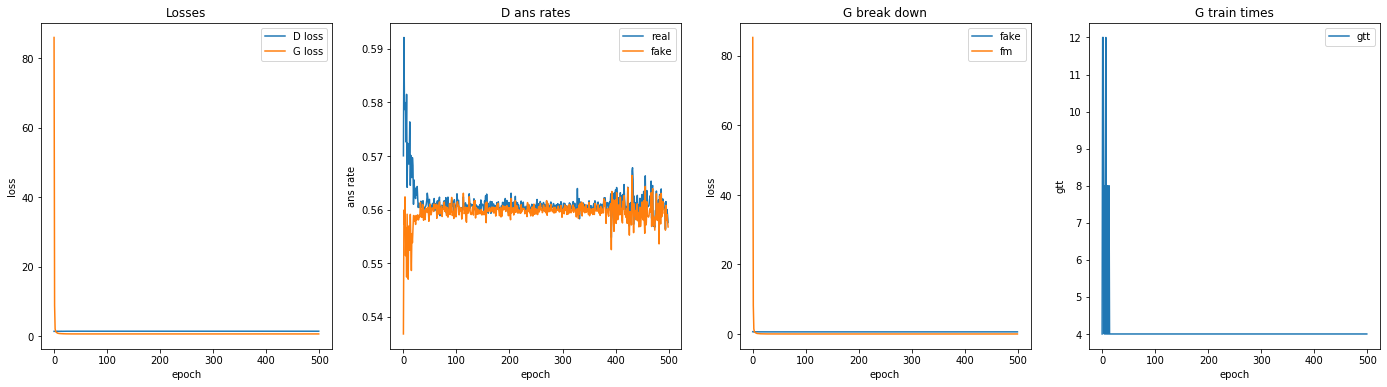

In [19]:
show_status_graph_gan_adaptive(status_dict, holizon=True, burn_in=0)

生成データの画像を表示

5 images found in ../datasets/theorytab/midinet/learning/midinet_noprev_nochordD
00: fake_samples_epoch100.png
01: fake_samples_epoch200.png
02: fake_samples_epoch300.png
03: fake_samples_epoch400.png
04: fake_samples_epoch500.png
input the number of image:4


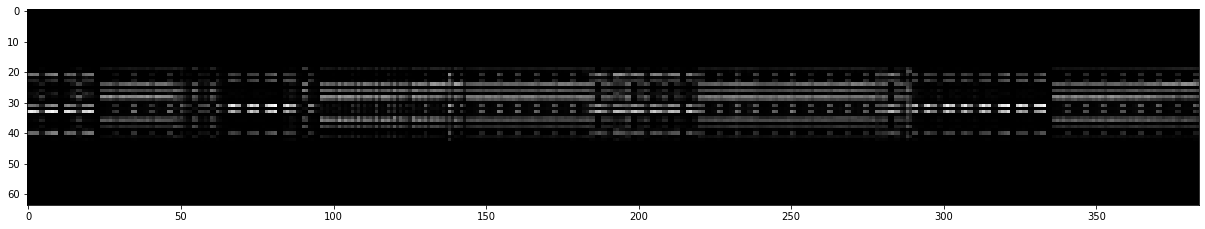

In [20]:
show_sample(save_dir)